+ **NOTE:** This notebook is trained on Google Colaboratory

## Setting Dataset

In [0]:
# from google.colab import files
# files.upload() #upload kaggle.json

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets download -d puneet6060/intel-image-classification -p /tmp/

100% 346M/346M [00:04<00:00, 97.9MB/s]



## Importing Libraries

In [0]:
import tensorflow as tf

import os
import zipfile
import random
import numpy as np
import re
import shutil

import matplotlib.image as mpImg
import matplotlib.pyplot as plt
%matplotlib inline

## Analyzing Dataset

In [0]:
local_training_zip = '/tmp/intel-image-classification.zip'
if zipfile.is_zipfile(local_training_zip):
    zip_ref = zipfile.ZipFile(file=local_training_zip, mode='r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()

In [0]:
print('No. of Building photos in training set:', len(os.listdir('/tmp/seg_train/seg_train/buildings')))
print('No. of Forest photos in training set:', len(os.listdir('/tmp/seg_train/seg_train/forest')))
print('No. of Glacier photos in training set:', len(os.listdir('/tmp/seg_train/seg_train/glacier')))
print('No. of Mountain photos in training set:', len(os.listdir('/tmp/seg_train/seg_train/mountain')))
print('No. of Sea photos in training set:', len(os.listdir('/tmp/seg_train/seg_train/sea')))
print('No. of Street photos in training set:', len(os.listdir('/tmp/seg_train/seg_train/street')))
print('')
print('No. of Building photos in testing set:', len(os.listdir('/tmp/seg_test/seg_test/buildings')))
print('No. of Forest photos in testing set:', len(os.listdir('/tmp/seg_test/seg_test/forest')))
print('No. of Glacier photos in testing set:', len(os.listdir('/tmp/seg_test/seg_test/glacier')))
print('No. of Mountain photos in testing set:', len(os.listdir('/tmp/seg_test/seg_test/mountain')))
print('No. of Sea photos in testing set:', len(os.listdir('/tmp/seg_test/seg_test/sea')))
print('No. of Street photos in testing set:', len(os.listdir('/tmp/seg_test/seg_test/street')))

No. of Building photos in training set: 2191
No. of Forest photos in training set: 2271
No. of Glacier photos in training set: 2404
No. of Mountain photos in training set: 2512
No. of Sea photos in training set: 2274
No. of Street photos in training set: 2382

No. of Building photos in testing set: 437
No. of Forest photos in testing set: 474
No. of Glacier photos in testing set: 553
No. of Mountain photos in testing set: 525
No. of Sea photos in testing set: 510
No. of Street photos in testing set: 501


Random 5 images of each category from training set


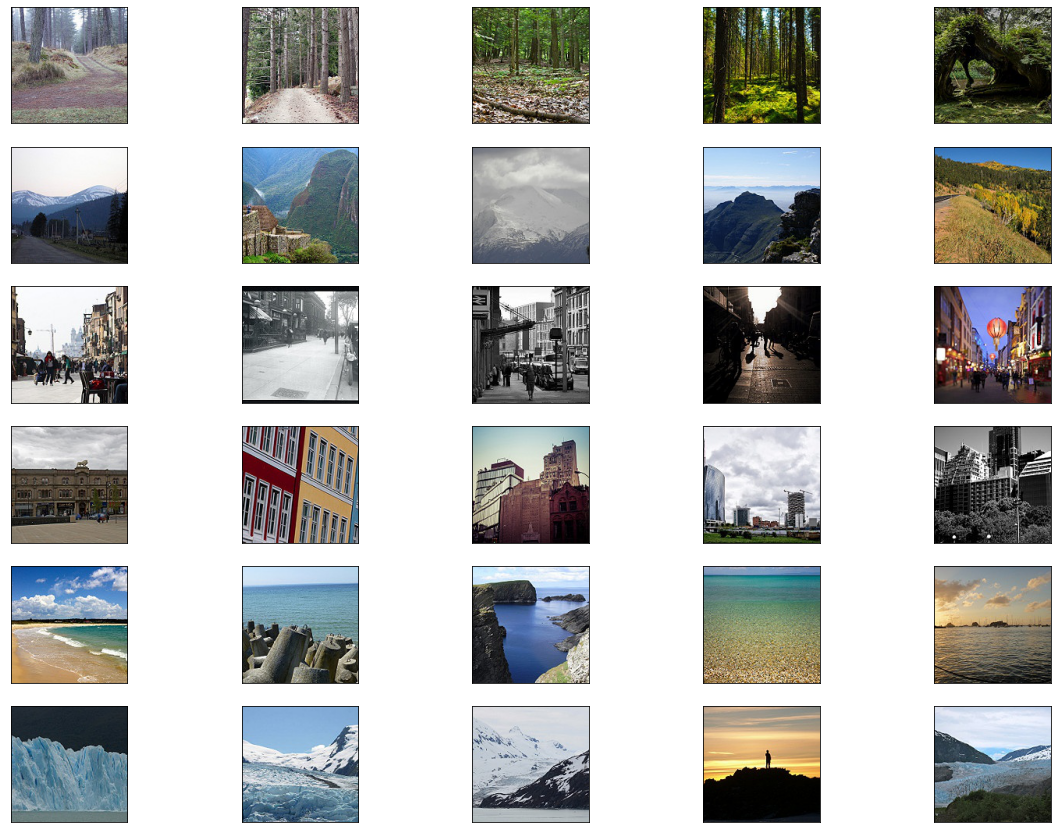

In [0]:
print('Random 5 images of each category from training set')
plt.figure(figsize=(20, 15))
i = 1
while(i<6):

    for k,j in enumerate(os.listdir('/tmp/seg_train/seg_train')):
        img_name = random.choice(os.listdir('/tmp/seg_train/seg_train/'+j+'/'))
        img = mpImg.imread('/tmp/seg_train/seg_train/' + j + '/' + img_name)
        plt.subplot(len(os.listdir('/tmp/seg_train/seg_train')), 5, 5*k+i)
        plt.imshow(img)
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
    
    i += 1

## Loading Pre-trained Model

In [0]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    input_shape=(150, 150, 3),
    weights='imagenet'
)

87916544/87910968 [==============================] - 1s 0us/step


## Freezing all the layers

In [0]:
for layer in pre_trained_model.layers:
    layer.trainable = False

## Pre-trained Model Summary

In [0]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Selecting the desired last layer of pre-trained model

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

## Adding own layers after desired last layer of pre-trained model

In [0]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)

## Grouping layers into an Object

In [0]:
model = tf.keras.Model(pre_trained_model.input, x)

## New/Modified Model Summary

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Compiling the Model

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

## Importing Images from Directories

In [0]:
# Training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/tmp/seg_train/seg_train/',
    target_size=(150, 150),
    batch_size=140,
    class_mode='categorical'
)

# Validation data
validate_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

validate_generator = validate_datagen.flow_from_directory(
    '/tmp/seg_test/seg_test/',
    target_size=(150, 150),
    batch_size=25,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Setting the Callback for the Model

In [0]:
# callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/model/cp.ckpt',
                                                 monitor='val_loss',
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 save_freq='epoch',
                                                 verbose=1)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

## Training the Model

In [0]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validate_generator,
    validation_steps=120,
    callbacks=[early_stopping, cp_callback]
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.8653 - acc: 0.8467
Epoch 00001: val_loss improved from inf to 0.26552, saving model to /content/drive/My Drive/Colab Notebooks/model/cp.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model/cp.ckpt/assets
100/100 [==============================] - 47s 467ms/step - loss: 0.8653 - acc: 0.8467 - val_loss: 0.2655 - val_acc: 0.9047
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.2118 - acc: 0.9254
Epoch 00002: val_loss improved from 0.26552 to 0.23198, saving model to /content/drive/My Drive/Colab Notebooks/model/cp.ckpt
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/model/cp.ckpt/assets
100/100 [==============================] - 45s 454ms/step - loss: 0.2118 - acc: 0.9254 - val_loss: 0.2320 - val_acc: 0.9210
Epoch 3/5
100/100 [==============================] 

## Analyzing the Trained Model

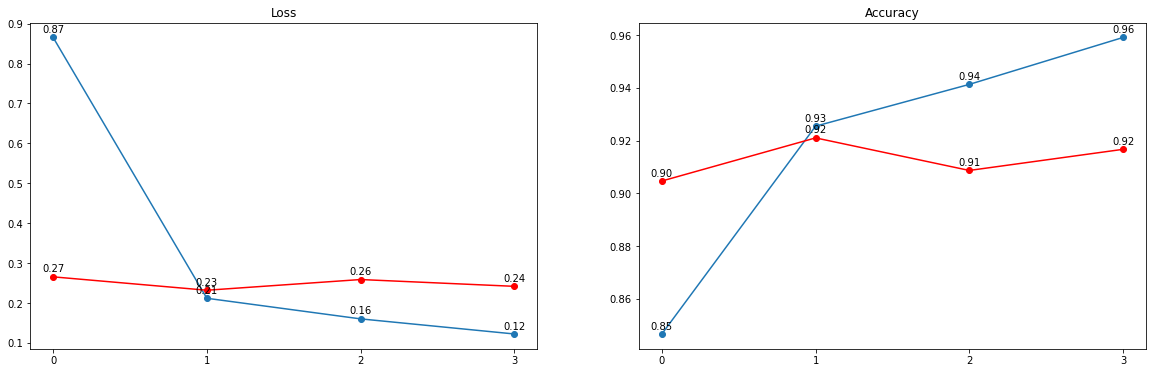

In [0]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], marker='o')
plt.title('Loss')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_loss'], color='r', marker='o')
plt.title('Loss')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_loss']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], marker='o')
plt.title('Accuracy')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['acc']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center

plt.plot(history.history['val_acc'], color='r', marker='o')
plt.title('Accuracy')
plt.xticks(history.epoch)
for x, y in zip(history.epoch, history.history['val_acc']):
    label = "{:.2f}".format(y)
    plt.annotate(label,                               # this is the text
                 (x, y),                              # this is the point to label
                 textcoords="offset points",          # how to position the text
                 xytext=(0, 5),                       # distance from text to points (x,y)
                 ha='center')                         # horizontal alignment can be left, right or center


## Class Indices for Model

In [0]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

## Testing the Model against a Image

In [0]:
# loading best saved model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/model/cp.ckpt')

In [0]:
# custom image path from directory
img_path = '/content/drive/My Drive/Colab Notebooks/img1.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150), color_mode='rgb')
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = img_tensor/255.0

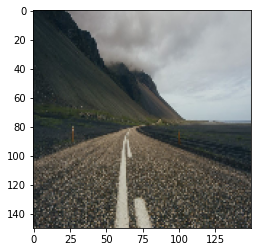

In [0]:
plt.imshow(img_tensor.reshape(150, 150, 3))

In [0]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [0]:
pred = list(model.predict(img_tensor)[0])
print(list(train_generator.class_indices)[pred.index(max(pred))])

mountain
